<h1>Naive analysis of 1I/2017 U1 (ʻOumuamua) MPC magnitude observations</h1>

Data from MPC: https://www.minorplanetcenter.net/db_search/show_object?utf8=%E2%9C%93&object_id=A%2F2017+U1

- [MPEC 2017-U265](https://www.minorplanetcenter.net/mpec/K17/K17UQ5.html)
- [MPEC 2017-U263](https://www.minorplanetcenter.net/mpec/K17/K17UQ3.html)
- [MPEC 2017-U183](https://www.minorplanetcenter.net/mpec/K17/K17UI3.html)
- [MPEC 2017-U181](https://www.minorplanetcenter.net/mpec/K17/K17UI1.html)
- [MPEC 2017-V01](http://minorplanetcenter.net/mpec/K17/K17V01.html)


DISCLAIMER: this is experimental code and the results drawn will be inconclusive due to unknown uncertainties in the input data and the nature of the magnitude measurements reported to the MPC. See for example the below discussion

https://groups.yahoo.com/neo/groups/mpml/conversations/topics/33263

The intention here is to perform a naive analysis anyway in order to:

- compare results to future light curves produced with higher quality methods (for example: https://arxiv.org/abs/1711.01402)
- improve own skills and methods to be applied to other datasets
    
So, can something be said about the rotation period using the reported magnitudes to the MPC?


In [3]:
%matplotlib inline 
%run functions.py


C:\Miniconda3\envs\astro\lib\site-packages\astropy\config\configuration.py:541: ConfigurationMissingWarning: Configuration defaults will be used due to OSError:22 on None
  warn(ConfigurationMissingWarning(msg))


In [17]:
asteroidHorizonsName = 'A/2017 U1'

useWebInput = True

lightcurveSourceFile = 'https://www.minorplanetcenter.net/tmp/A_2017_U1.txt' if useWebInput else 'a2017u1_mpc.txt'

mpcData = pd.read_fwf(lightcurveSourceFile,
    header = None,
    widths = [13, 1, 1, 16, 12, 12, 10, 5, 1, 6, 3],
    usecols= [1, 2, 3, 7, 8, 9, 10],
    names = ['note1', 'note2', 'decimalDaytime', 'mag', 'band', 'blank', 'observatory']
)

In [18]:
#mpcData.to_csv('a2017u1.csv')

In [29]:
data = mpcData

data['time'] = data.decimalDaytime.apply(timeFromDecimalDaytime)
data['when'] = data.apply(lambda row: row.time.datetime.strftime('%Y-%b-%d %H:%M:%S'), axis=1)
data['timestamp'] = data.apply(lambda row: row.time.jd, axis=1)
data['date'] = data.apply(lambda row: row.time.datetime.strftime('%Y-%m-%d'), axis=1)


In [30]:
if False:
    dateList = data.date.unique()
    intervals = getHorizonsIntervalsForDates(dateList)
    ephemerides = pd.DataFrame()

    for interval in intervals:
        ephemerides = pd.concat([ephemerides,
            getReferenceMagnitudesFromHorizons(asteroidHorizonsName, interval[0], interval[1])
            ])
        
ephemerides = pd.read_fwf(
    'A2017U1_horizons.txt',
    widths=[22, 25, 6, 19, 10, 9, 5, 6],
    usecols=[0, 2],
    names=['date', 'APmag'])

def APmagFromEphemerides(eph):
    row = ephemerides.loc[ephemerides['date'] == (eph[0:15] + '00')].iloc[0]
    return float(row.APmag)

data['APmag'] = data.apply(lambda row: APmagFromEphemerides(row.when), axis=1)
data['magDelta'] = data.apply(lambda row: row.mag - row.APmag, axis=1)

In [31]:
relevantObservations = data

#relevantObservations = data.loc[data['timestamp'] > 1.508406e+09]
#relevantObservations.reset_index(inplace=True)
#relevantObservations


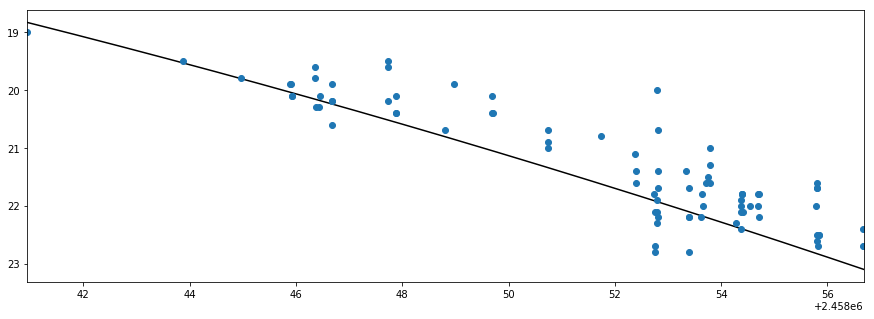

In [32]:
xs = [pd.to_datetime(d) for d in relevantObservations.when]

import numpy.polynomial.polynomial as poly
ts = relevantObservations.timestamp
coefs = poly.polyfit(ts, relevantObservations.APmag, 2)
x_new = np.linspace(ts[0], ts[len(ts) - 1], num=len(ts)*10)
ffit = poly.Polynomial(coefs)


plt.rcParams['figure.figsize'] = (15, 5);
plt.plot(x_new, ffit(x_new), color='k', lw=1.5, zorder=1);
plt.scatter(ts, relevantObservations.mag, zorder=2);
plt.xlim(ts[0], ts[len(ts) - 1]);
plt.gca().invert_yaxis();


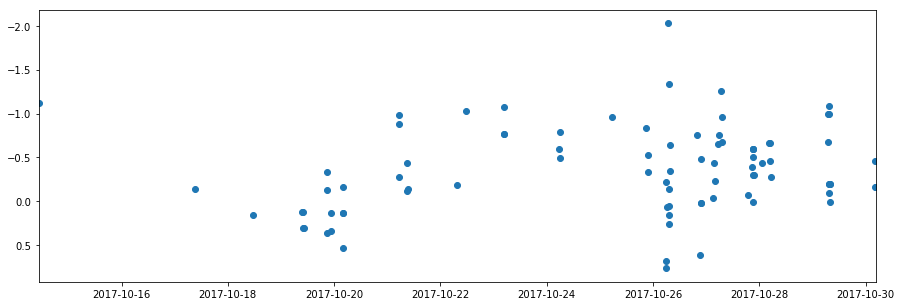

In [33]:
def plotMagDeltas(observations):
    xs = [pd.to_datetime(d) for d in observations.when]

    plt.rcParams['figure.figsize'] = (15, 5);
    plt.scatter(xs, observations.magDelta);
    plt.xlim(xs[0], xs[len(xs) - 1]);
    plt.gca().invert_yaxis();

plotMagDeltas(relevantObservations)

Best frequency (cycles per day) =  0.00635008830601
Best period (hours) =  3779.47499994


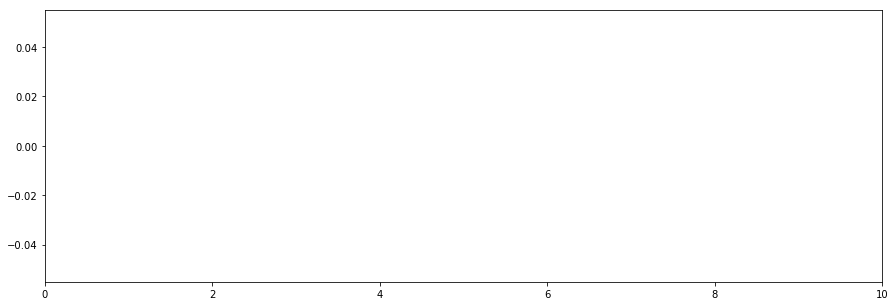

In [34]:
from astropy.stats import LombScargle
import astropy.units as u

def naiveLombScargle(observations):
    a = observations.timestamp.values
    startTimestamp = a[0] #datetime.fromtimestamp(a[0])
    #a = [((datetime.fromtimestamp(x)-startTimestamp).total_seconds() / 3600) for x in a]
    a = a - a[0]
    #a = a * u.hour
    #a = a * u.day
    b = observations.magDelta.values
    freq, power = LombScargle(a, b).autopower(nyquist_factor=100)

    plt.rcParams['figure.figsize'] = (15, 5);
    plt.figure();
    plt.plot(1/freq, power);
    plt.xlim(0,10);

    best_frequency = freq[np.argmax(power)]

    print('Best frequency (cycles per day) = ', best_frequency)
    print('Best period (hours) = ', (1/best_frequency) * 24)
    
    #t_fit = np.linspace(0*u.hour,1000*u.hour)
    #y_fit = LombScargle(a, b).model(t_fit, best_frequency)
    
    #plt.plot(y_fit);
    
naiveLombScargle(relevantObservations)

Best frequency (cycles per day) =  31.0680530935
Best period (hours) =  0.772497714221


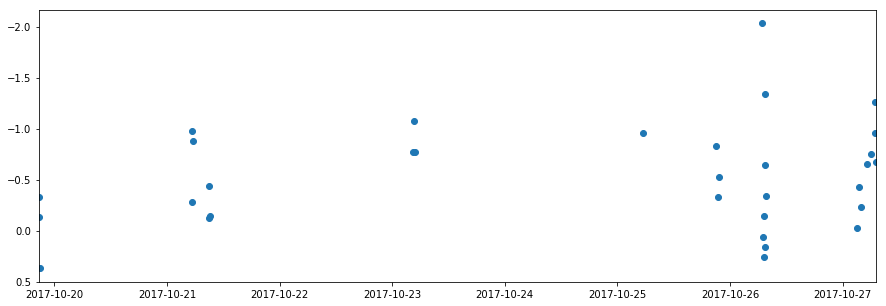

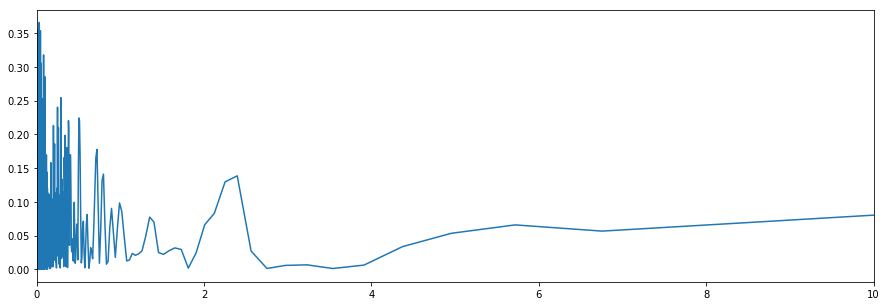

In [35]:
relevantObservations = data[(data.band == 'R')]
plotMagDeltas(relevantObservations)
naiveLombScargle(relevantObservations)


Best frequency (cycles per day) =  4.76891631782
Best period (hours) =  5.03258988008


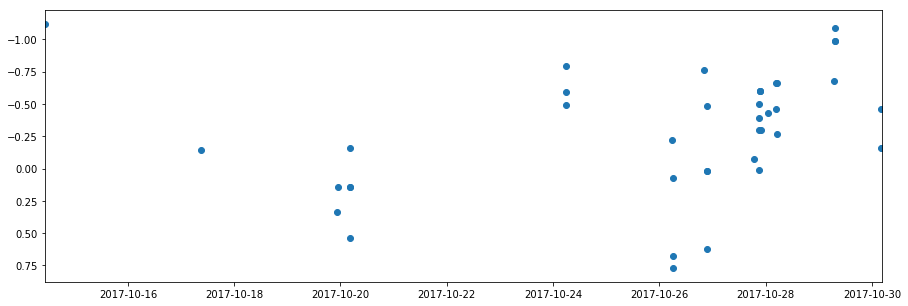

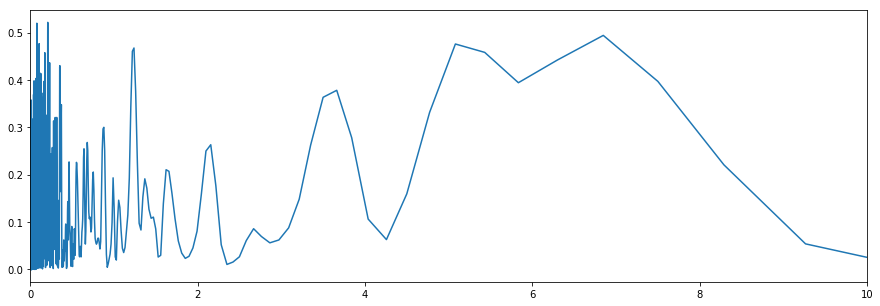

In [37]:
gBandObservations = data[(data.band == 'G')]
plotMagDeltas(gBandObservations)
naiveLombScargle(gBandObservations)

Best frequency (cycles per day) =  6.57313061551
Best period (hours) =  3.65122822044


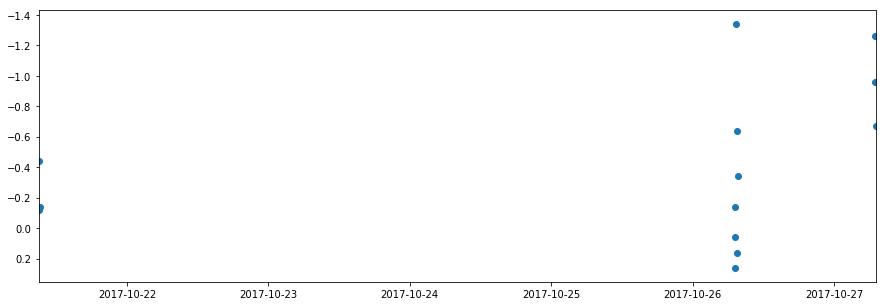

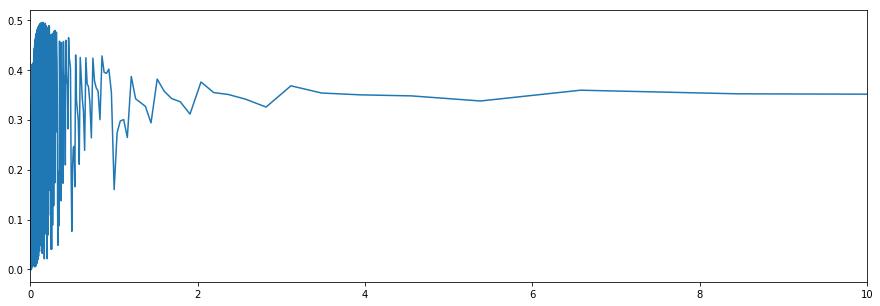

In [38]:
relevantObservations = data[(data.band == 'R') & (data.observatory == '926')]
plotMagDeltas(relevantObservations)
naiveLombScargle(relevantObservations)